In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 100 #higher precision
from scipy.optimize import curve_fit

In [2]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import pandas as pd


mp.mp.dps = 100

T_c = 2/(np.log(1+np.sqrt(2)))
T = np.linspace(0.1 , T_c + 0.5, 40)

X_vals = [4, 6, 8]

Y_vals = [8, 10, 12, 14, 16]

probs = [0]

alpha=0.8

beta=0.000001

walker_wl=8

overlap_wl=0.25

seed_hist=1

seed_run=42

num_interactions=100

replica_exchange_steps=50

boundary_type=0

boundary = {0: "periodic", 1: "open", 2: "cylinder"}

intervals_wl=[20]

iterations=[5000]

num_walker_prerun=150

num_intervals_prerun=30

end_seed=((seed_hist + num_interactions - 1))

# ------------------------------------------------------------

def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")

    return data

def fit_function_square(N, a,b,c,d,e):
    M = N
    S = M*N
    return a + b*(M+N)/S + c*np.log(S)/S + d*1/S + e*1/np.power(S,3/2) # + ... higher order terms

def linear_fit(x, m, b):
    return m * x + b

def fit_function_cylinder(N, a,b,c):
    return a + b/N**2 + c/N**4 # + ... higher order terms


def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res


def get_c_term_cylinder(f_lst, N_lst):
    fit = curve_fit(fit_function_cylinder, N_lst, f_lst)
    parameters = fit[0]
    c_term = parameters[1]*6/np.pi/(-T_c)
    return c_term

def process_data(data, batch_results: list, p, x, y, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'x': x,
                'y': y,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })

# ------------------------------------------------------
# Reading results here

results = []
for interval in intervals_wl:
    for iteration in iterations:
        for x in X_vals:
            for y in Y_vals:
                for p in probs:
                    res = []
                    for error in ["I"]:
                        filename = f"../results/{boundary[boundary_type]}/prob_{p:.6f}/X_{x}_Y_{y}/error_class_{error}/StitchedHistogram_intervals_{interval}_iterations_{iteration}_overlap_{overlap_wl:.6f}_walkers_{walker_wl}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{replica_exchange_steps}.txt"
                        try:
                            data = read_results_file(filename)
                            if data:
                                process_data(data, results, p, x, y, error)
                        except:
                            print(f"not found: {filename}")

results_df = pd.DataFrame()
for t in T:
    results_t_df = pd.DataFrame(results)
    results_t_df['free_energy'] = results_t_df.apply(lambda row: free_energy(row['E'], row['log_g'], t), axis=1)
    results_t_df['temp'] = t
    results_t_df['free_energy'] = results_t_df['free_energy'].astype(float)
    results_df = pd.concat([results_df, results_t_df], ignore_index=True)


# Group by 'prob', 'x', 'y', 'error', 'temp' and calculate both mean and variance
aggregated_results_df = results_df.groupby(['prob', 'x', 'y', 'error', 'temp']).agg(
    avg_free_energy=('free_energy', 'mean'),
    var_free_energy=('free_energy', 'var')
).reset_index()

# Calculate the exponential ratio for extrapolating y -> inf limit but with scaling dimension 1?
aggregated_results_df['exp_ratio'] = np.exp(-2 * np.pi * aggregated_results_df['x'] / aggregated_results_df['y']) / (aggregated_results_df['y'] * aggregated_results_df['x'])

# Group the data by unique pairs of 'x' and 'temp'
unique_pairs = results_df.groupby(['x', 'temp']).size().reset_index().drop(columns=0)

# List to store extrapolated intercepts
intercepts_data = []

# # Create a plot for the extrapolation
# plt.figure(figsize=(8, 6))

# Iterate over each unique pair of (x, temp)
for _, (x_val, t_val) in unique_pairs.iterrows():
    # Filter the DataFrame for the specific x and temperature
    subset_df = aggregated_results_df[(aggregated_results_df['x'] == x_val) & (aggregated_results_df['temp'] == t_val)]

    # Ensure there are enough data points to fit
    if len(subset_df) > 1:
        exp_ratios = subset_df['exp_ratio']
        avg_free_energies = subset_df['avg_free_energy'] / (x_val * subset_df['y'])
        errors = np.sqrt(subset_df['var_free_energy']) / (x_val * subset_df['y'])

        # Fit a linear model to the data points (exp_ratio vs avg_free_energy)
        popt, pcov = curve_fit(linear_fit, exp_ratios, avg_free_energies)

        # Extrapolate to find the y-intercept (where exp_ratio = 0)
        y_intercept = linear_fit(0, *popt)

        # Calculate the variance of the intercept estimate
        # The variance of the parameters can be found in the covariance matrix (pcov)
        intercept_variance = pcov[0, 0]  # Assuming popt[0] is the intercept
        intercept_std_dev = np.sqrt(intercept_variance)

        # Store the x, t, and intercept data
        intercepts_data.append({
            'x_value': x_val,
            'temp_value': t_val,
            'intercept_free_energy': y_intercept,
            'intercept_variance': intercept_variance,
            'intercept_std_dev': intercept_std_dev
        })

        # # Plot the original points with error bars
        # plt.errorbar(
        #     exp_ratios,
        #     avg_free_energies,
        #     yerr=errors,
        #     fmt='o', capsize=5, label=f'X: {x_val}, T: {t_val}', color=np.random.rand(3,)
        # )

        # # Plot the linear fit over the entire exp_ratio range (extrapolated)
        # x_vals_for_line = np.linspace(0, max(exp_ratios) * 2, 100)  # Extended range for the line
        # plt.plot(x_vals_for_line, linear_fit(x_vals_for_line, *popt), linestyle='--', color='gray')

        # # Mark the y-intercept on the plot
        # plt.scatter(0, y_intercept, color='red', zorder=5)
        # plt.text(0, y_intercept, f'X: {x_val}, T: {t_val}, Intercept: {y_intercept:.2f}', fontsize=9, ha='left', va='bottom')

# Create a DataFrame to store the intercept results
intercepts_df = pd.DataFrame(intercepts_data)

# # Add labels and title to the plot
# plt.xlabel('Exponential Ratio')
# plt.ylabel('Averaged Free Energy')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()


not found: ../results/periodic/prob_0.000000/X_4_Y_10/error_class_I/StitchedHistogram_intervals_20_iterations_5000_overlap_0.250000_walkers_8_alpha_0.800000_beta_0.0000010000_exchange_offset50.txt


In [3]:
intercepts_df

,x_value,temp_value,intercept_free_energy,intercept_variance,intercept_std_dev
0,4.0,0.100000,-2.002843,0.000331,0.018201
1,4.0,0.168441,-2.004788,0.000940,0.030658
2,4.0,0.236881,-2.006734,0.001859,0.043115
3,4.0,0.305322,-2.008680,0.003088,0.055571
4,4.0,0.373763,-2.010625,0.004628,0.068029
...,...,...,...,...,...
115,8.0,2.495423,-2.207572,19.844797,4.454750
116,8.0,2.563863,-2.235580,14.529925,3.811814
117,8.0,2.632304,-2.265459,9.973853,3.158141
118,8.0,2.700745,-2.296967,6.473801,2.544367


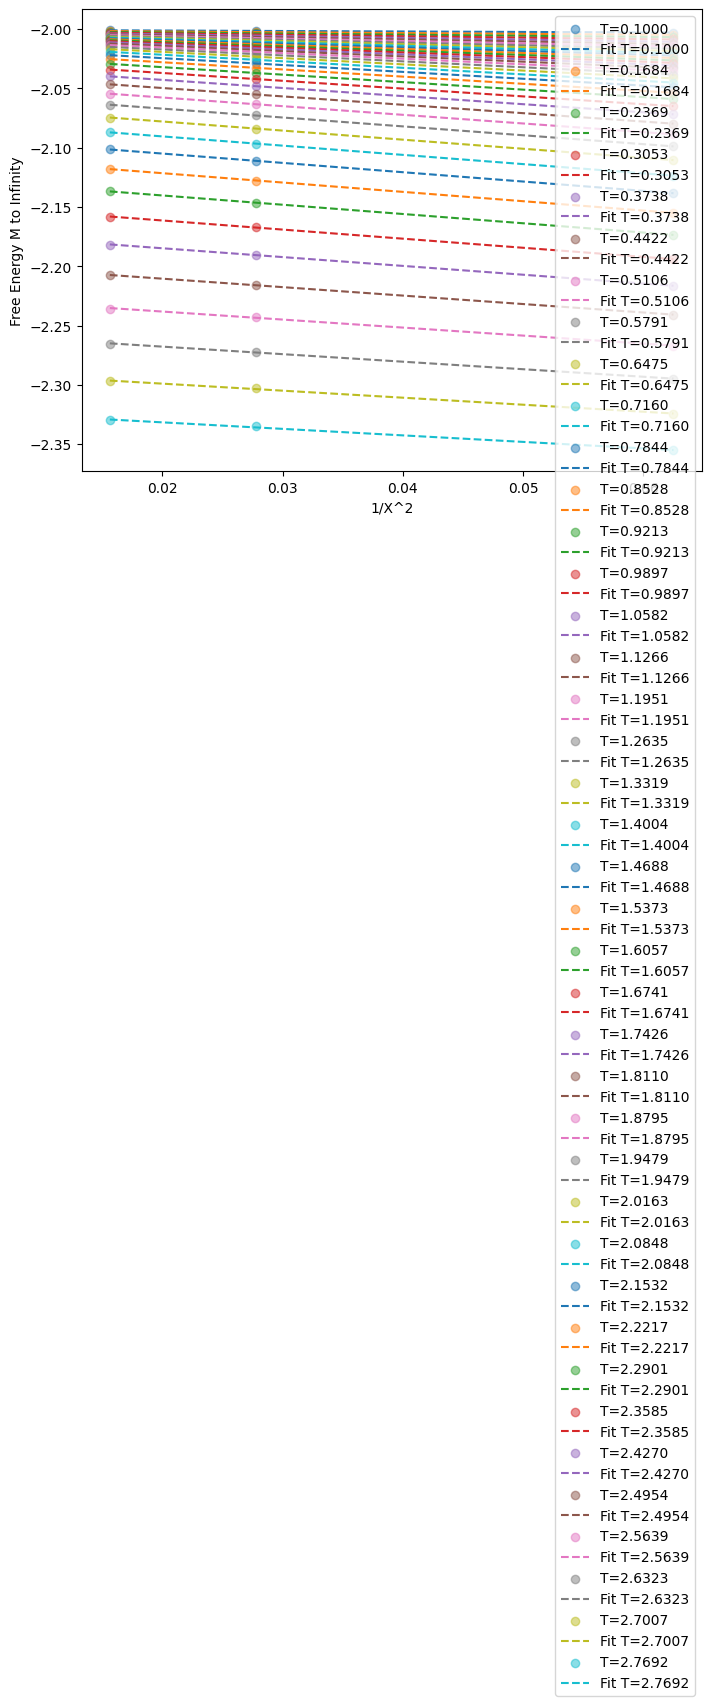

In [4]:
# Get central charge by linear fit of 1/N**2 dependency
c=[]

intercepts_df['inverse_x_squared'] = 1 / (intercepts_df['x_value'] ** 2)

unique_temps = intercepts_df['temp_value'].unique()

plt.figure(figsize=(8, 6))


for t_val in unique_temps:
    temp_df = intercepts_df[intercepts_df['temp_value'] == t_val]
    if len(temp_df) > 1:
#---------------------
        popt, pcov = curve_fit(linear_fit, temp_df['inverse_x_squared'], temp_df['intercept_free_energy'])

        # Extract slope and intercept variances
        slope_variance, intercept_variance = np.diag(pcov)
        slope_std_dev = np.sqrt(slope_variance)
        intercept_std_dev = np.sqrt(intercept_variance)

        # Store the results
        c.append({
            'temp': t_val,
            'slope': popt[0],
            'intercept': popt[1],
            'slope_std_dev': slope_std_dev,
            'intercept_std_dev': intercept_std_dev
        })

        # Generate x values for plotting the fit line
        x_fit = np.linspace(min(temp_df['inverse_x_squared']), max(temp_df['inverse_x_squared']), 100)
        y_fit = linear_fit(x_fit, *popt)

        plt.scatter(temp_df['inverse_x_squared'], temp_df['intercept_free_energy'], label=f'T={t_val:.4f}', alpha=0.5)
        # plt.errorbar(temp_df['inverse_x_squared'], temp_df['free_energy_M_to_inf'], yerr=intercept_std_dev, fmt='o', color=colors[T.index(t_val)], label=f'T={t_val}', capsize=5)
        plt.plot(x_fit, y_fit, linestyle='--', label=f'Fit T={t_val:.4f}')

# Final plot adjustments
plt.xlabel('1/X^2')
plt.ylabel('Free Energy M to Infinity')
plt.grid(False)
plt.legend()

# Show the plot
plt.show()
#----------------------


In [5]:
for res in c:
    res['c']=-6*res['slope']/(res['temp']*mp.pi)

c_df = pd.DataFrame(c)

In [6]:
c_df

,temp,slope,intercept,slope_std_dev,intercept_std_dev,c
0,0.100000,-0.039427,-2.000376,0.000447,1.810592e-05,0.75299686919408126724322867405431546718632592...
1,0.168441,-0.066411,-2.000632,0.000753,3.050479e-05,0.75299725863458403115447688210669762721099997...
2,0.236881,-0.093395,-2.000889,0.001059,4.289256e-05,0.75299720987452103679729197607654100058521077...
3,0.305322,-0.120379,-2.001146,0.001365,5.528692e-05,0.75299768245122884050934824427652843094199396...
4,0.373763,-0.147363,-2.001403,0.001671,6.767909e-05,0.75299749115184688783419484253816273070270805...
5,0.442203,-0.174347,-2.001660,0.001977,8.007893e-05,0.75299746986102729197171034238501157769074654...
6,0.510644,-0.201331,-2.001918,0.002283,9.246334e-05,0.75299760886604620612953845057569125300618348...
7,0.579085,-0.228315,-2.002175,0.002589,1.048585e-04,0.75299765605021539967844327517064245784549134...
8,0.647525,-0.255299,-2.002434,0.002895,1.172499e-04,0.75299747985297792482012961799931555733233815...
9,0.715966,-0.282283,-2.002699,0.003200,1.296310e-04,0.75299741774937340243465107216774051981823239...


/tmp/ipykernel_1931358/4173163654.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


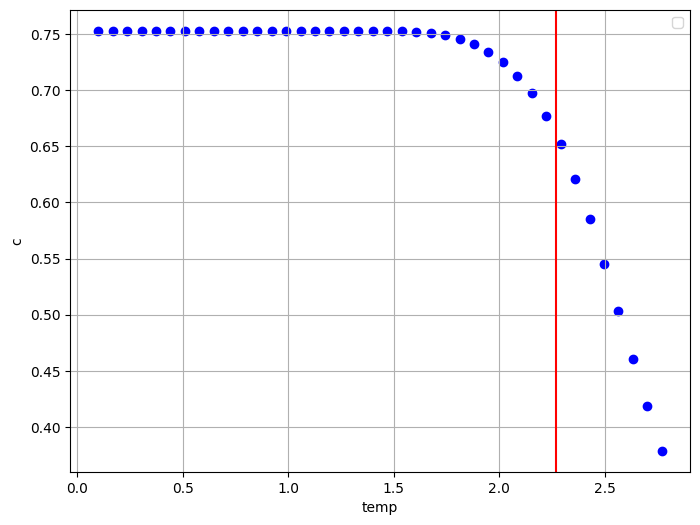

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter( c_df['temp'], c_df['c'], color='blue')
plt.xlabel('temp')
plt.ylabel('c')
plt.axvline(x=T_c, color='red')
plt.grid(True)
plt.legend()
plt.show()

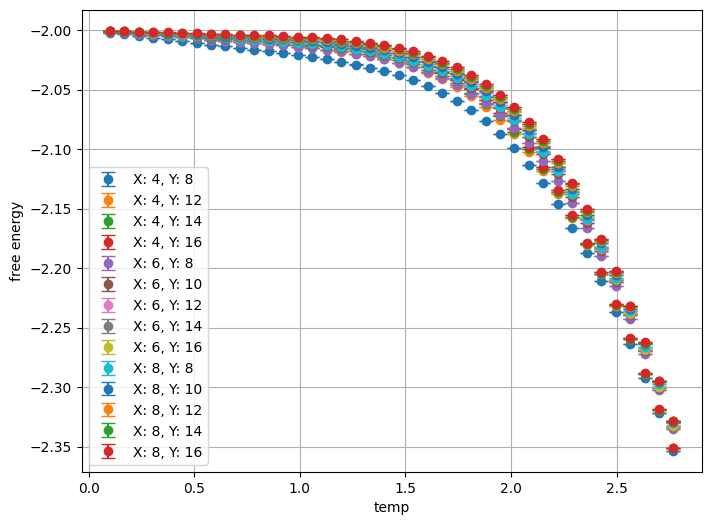

In [11]:
aggregated_results_df

plt.figure(figsize=(8, 6))
unique_keys = results_df.groupby(['x', 'y']).size().reset_index().drop(columns=0)

for _, (x,y) in unique_keys.iterrows():
    xy_df = aggregated_results_df[(aggregated_results_df['x'] == x) & (aggregated_results_df['y'] == y)]
    # plt.plot(xy_df['temp'], xy_df['avg_free_energy'])
    plt.errorbar(
            xy_df['temp'],
            xy_df['avg_free_energy']/(x*y),
            yerr=xy_df['var_free_energy']/(x*y)**2,
            fmt='o', capsize=5, label=f'X: {x}, Y: {y}'
        )
plt.xlabel('temp')
plt.ylabel('free energy')
plt.axvline(x=T_c, color='red')
plt.grid(True)
plt.legend()
plt.show()